In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [41]:
import os
import glob
import time
import json
import math
import random
import itertools
import requests
from zipfile import ZipFile
from collections import Counter

import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import (
    CLIPProcessor,
    CLIPModel,
    CLIPTextModel,
    AutoTokenizer,
    AutoProcessor,
    CLIPVisionModel,
    CLIPVisionModelWithProjection,
    CLIPTextModelWithProjection,
)
from datasets import load_dataset
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Dataset statistics

In [6]:
# load huggingface dataset
with ZipFile('./Final_Dataset.zip', 'r') as f:
    f.extractall()

dataset_train = load_dataset('Final_Dataset', split='train')
# dataset_test = load_dataset('Final_Dataset', split='test')
print(dataset_train.shape)
# print(dataset_test.shape)

Found cached dataset final_dataset (/home/dchakraborty_umass_edu/.cache/huggingface/datasets/final_dataset/default/0.0.0/34d6aec3bec727cabad6cf5f2f793db53c21f6631afa14041c5152f7bb59696c)


(257, 4)


bigger
smaller


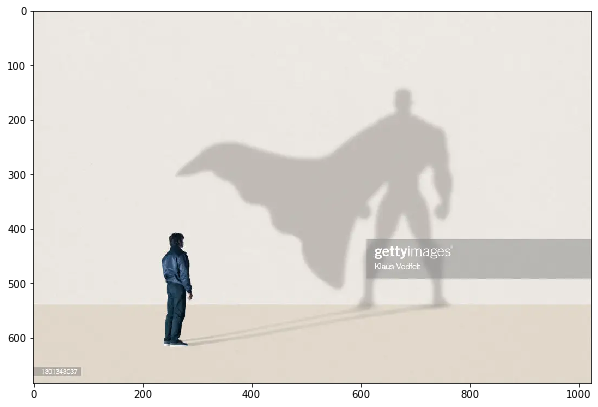

In [7]:
# visualize an example
idx = np.random.choice(dataset_train.shape[0])
print(dataset_train[idx]['adjective'])
print(dataset_train[idx]['antonym'])
plt.imshow(dataset_train[idx]['image'])

In [9]:
# load the prompts
with open('./all_prompts.json', 'r') as f:
    all_prompts = json.load(f)

print("Example prompt:")
rand_adj = random.choice(list(all_prompts.keys()))
print(f"adjective: {rand_adj}, prompts_dict: {all_prompts[rand_adj]['human']}")

Example prompt:
adjective: shorter, prompts_dict: ['The object on one side is shorter than the object on the other side.', 'There are two objects in the image. They can be compared using the adjective shorter.', 'The objects in the image could be compared using the adjective "shorter"', 'shortness could be used to compare the objects in the image', 'shortness can be used to compare the objects in the image', 'The objects in the image can be compared using the adjective "shorter"']


In [10]:
# load the annotations to see
train_df = pd.read_csv("./Final_Dataset/metadata/train.csv")
train_df['image_name'] = train_df['image_name'] + ".jpg"
train_df.head(10)

,image_name,adjective_1,adjective_2
0,p_0.jpg,bigger,smaller
1,p_1.jpg,cleaner,dirtier
2,p_2.jpg,hairier,balder
3,p_3.jpg,younger,older
4,p_5.jpg,colder,hotter
5,p_6.jpg,taller,shorter
6,p_7.jpg,harder,softer
7,p_8.jpg,drier,wetter
8,p_9.jpg,nearer,farther
9,p_11.jpg,fatter,skinnier


In [11]:
# Load Adjectives (No None)
adjectives_list = train_df['adjective_1'].tolist()
gt_list = adjectives_list
# Load Antonyms (Does have None)
antonyms_list = train_df['adjective_2'].tolist()
# create antonym --> adjective dict
ant_to_adj = {k: v for k, v in zip(antonyms_list, adjectives_list)}
ant_to_adj.pop("None")

adjectives_list = list(set(adjectives_list))
antonyms_list = set(antonyms_list)
antonyms_list.remove("None")
antonyms_list = list(antonyms_list)
unique_adjectives = adjectives_list + antonyms_list
print(f"{len(adjectives_list)=}, {len(antonyms_list)=}, {len(unique_adjectives)=}")
adj_to_idx = {k: v for v,k in enumerate(adjectives_list)}
ant_to_idx = {k: v+len(adjectives_list) for v,k in enumerate(antonyms_list)}
antidx_to_adjidx = {ant_to_idx[ant]: adj_to_idx[ant_to_adj[ant]] for ant in antonyms_list}

len(adjectives_list)=39, len(antonyms_list)=30, len(unique_adjectives)=69


## Modeling

In [12]:
model_name = "openai/clip-vit-base-patch32"
# model_name = "openai/clip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

### Predictions averaged over individual human and AI generated prompts

In [14]:
class CLIPWrapper:
    def __init__(self, clip_model, clip_processor, adjectives, prompts):
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.adjectives = adjectives
        self.prompts = prompts

    def __call__(self, dataset):
        texts = self.prompts
        imgs = [data['image'] for data in dataset]
        filenames = [data['filename'] for data in dataset]
        true_labels = [data['adjective'] for data in dataset]
        inputs = self.clip_processor(text=texts, images=imgs, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=-1)
        # return probs, labels
        return probs, true_labels, filenames

In [15]:
# run on all human prompts
prompt_format = 'human'  # 'ai'
num_prompts = {'human': 6, 'ai': 93}[prompt_format]
top_1_accuracies = []
top_5_accuracies = []
for i in tqdm(range(num_prompts), desc="# Prompts"):
    input_prompts = [all_prompts[adj][prompt_format][i] for adj in adjectives_list]
    clipper = CLIPWrapper(model, processor, unique_adjectives, input_prompts)
    probs, true_labels, filenames = clipper(dataset_train)
    y_true = [adjectives_list.index(adj) for adj in true_labels]
    top_1_accuracies.append(top_k_accuracy_score(y_true, probs.cpu().numpy(), k=1))
    top_5_accuracies.append(top_k_accuracy_score(y_true, probs.cpu().numpy(), k=5))

# Prompts: 100%|█████████████████████████████████████████| 6/6 [03:01<00:00, 30.21s/it]


In [16]:
# print statistics
min_top1_acc, max_top1_acc = np.min(top_1_accuracies), np.max(top_1_accuracies)
mean_top1_acc, std_top1_acc = np.mean(top_1_accuracies), np.std(top_1_accuracies)
min_top5_acc, max_top5_acc = np.min(top_5_accuracies), np.max(top_5_accuracies)
mean_top5_acc, std_top5_acc = np.mean(top_5_accuracies), np.std(top_5_accuracies)
min_top1_idx, max_top1_idx = np.argmin(top_1_accuracies), np.argmax(top_1_accuracies)
min_top5_idx, max_top5_idx = np.argmin(top_5_accuracies), np.argmax(top_5_accuracies)
min_top1_prompt = all_prompts['thicker'][prompt_format][min_top1_idx]
max_top1_prompt = all_prompts['thicker'][prompt_format][max_top1_idx]
min_top5_prompt = all_prompts['thicker'][prompt_format][min_top5_idx]
max_top5_prompt = all_prompts['thicker'][prompt_format][max_top5_idx]

print(f"{min_top1_acc=:.4f}, {max_top1_acc=:.4f}, {mean_top1_acc=:.4f}, {std_top1_acc=:.4f},")
print(f"{min_top5_acc=:.4f}, {max_top5_acc=:.4f}, {mean_top5_acc=:.4f}, {std_top5_acc=:.4f},")
print(f"min top-1,5 accuracy prompts: \n {min_top1_prompt, min_top5_prompt}")
print(f"max top-1,5 accuracy prompts: \n {max_top1_prompt, max_top5_prompt}")

min_top1_acc=0.1790, max_top1_acc=0.2257, mean_top1_acc=0.1991, std_top1_acc=0.0173,
min_top5_acc=0.3969, max_top5_acc=0.4747, mean_top5_acc=0.4351, std_top5_acc=0.0257,
min top-1,5 accuracy prompts: 
 ('thickness can be used to compare the objects in the image', 'There are two objects in the image. They can be compared using the adjective thicker.')
max top-1,5 accuracy prompts: 
 ('The objects in the image can be compared using the adjective "thicker"', 'The object on one side is thicker than the object on the other side.')


In [17]:
# run on all ai prompts
prompt_format = 'ai'
num_prompts = {'human': 6, 'ai': 93}[prompt_format]
top_1_accuracies = []
top_5_accuracies = []
for i in tqdm(range(num_prompts), desc="# Prompts"):
    input_prompts = [all_prompts[adj][prompt_format][i] for adj in adjectives_list]
    clipper = CLIPWrapper(model, processor, unique_adjectives, input_prompts)
    probs, true_labels, filenames = clipper(dataset_train)
    y_true = [adjectives_list.index(adj) for adj in true_labels]
    top_1_accuracies.append(top_k_accuracy_score(y_true, probs.cpu().numpy(), k=1))
    top_5_accuracies.append(top_k_accuracy_score(y_true, probs.cpu().numpy(), k=5))

# Prompts: 100%|███████████████████████████████████████| 93/93 [44:26<00:00, 28.67s/it]


In [18]:
# print statistics
min_top1_acc, max_top1_acc = np.min(top_1_accuracies), np.max(top_1_accuracies)
mean_top1_acc, std_top1_acc = np.mean(top_1_accuracies), np.std(top_1_accuracies)
min_top5_acc, max_top5_acc = np.min(top_5_accuracies), np.max(top_5_accuracies)
mean_top5_acc, std_top5_acc = np.mean(top_5_accuracies), np.std(top_5_accuracies)
min_top1_idx, max_top1_idx = np.argmin(top_1_accuracies), np.argmax(top_1_accuracies)
min_top5_idx, max_top5_idx = np.argmin(top_5_accuracies), np.argmax(top_5_accuracies)
min_top1_prompt = all_prompts['thicker'][prompt_format][min_top1_idx]
max_top1_prompt = all_prompts['thicker'][prompt_format][max_top1_idx]
min_top5_prompt = all_prompts['thicker'][prompt_format][min_top5_idx]
max_top5_prompt = all_prompts['thicker'][prompt_format][max_top5_idx]

print(f"{min_top1_acc=:.4f}, {max_top1_acc=:.4f}, {mean_top1_acc=:.4f}, {std_top1_acc=:.4f},")
print(f"{min_top5_acc=:.4f}, {max_top5_acc=:.4f}, {mean_top5_acc=:.4f}, {std_top5_acc=:.4f},")
print(f"min top-1,5 accuracy prompts: \n {min_top1_prompt, min_top5_prompt}")
print(f"max top-1,5 accuracy prompts: \n {max_top1_prompt, max_top5_prompt}")

min_top1_acc=0.1284, max_top1_acc=0.2568, mean_top1_acc=0.1909, std_top1_acc=0.0268,
min_top5_acc=0.3424, max_top5_acc=0.5292, mean_top5_acc=0.4153, std_top5_acc=0.0421,
min top-1,5 accuracy prompts: 
 ('The objects in this image are different in thicker.', 'If the objects in the image differ in thickness, one might speculate that this could be used as a basis for comparison.')
max top-1,5 accuracy prompts: 
 ('thicker is an adjective that can be used to describe the objects in this image.', 'One of the objects in this image is thicker than the other.')


In [20]:
with open('ai_accuracies.json', 'w') as f:
    json.dump(
        {
            'top_1_accuracies': top_1_accuracies,
            'top_5_accuracies': top_5_accuracies,
        }, f
    )

In [113]:
all_prompts['thicker']['human'].index('The object on one side is thicker than the object on the other side.')

0

### Predictions using ensembled human and AI generated prompts

In [ ]:
model_name = "openai/clip-vit-base-patch32"
# model_name = "openai/clip-vit-large-patch14"
# model = CLIPModel.from_pretrained(model_name)
vision_model = CLIPVisionModelWithProjection.from_pretrained(model_name)
text_model = CLIPTextModelWithProjection.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vision_model = vision_model.to(device).eval()
text_model = text_model.to(device).eval()

In [82]:
# get all images embeddings
imgs = []
true_labels = []
for item in dataset_train:
    imgs.append(item['image'])
    true_labels.append(item['adjective'])

image_inputs = processor(images=imgs, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    image_embeddings = vision_model(**image_inputs).image_embeds
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)  # (257, 512)

In [117]:
# get all prompts' embeddings
prompt_format = 'human'
zeroshot_weights = []
for adj in adjectives_list:
    texts = all_prompts[adj][prompt_format]
    text_inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_embeddings = text_model(**text_inputs).text_embeds  # shape (93, 512)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
    text_embedding = text_embeddings.mean(dim=0)  # (512,)
    text_embedding /= text_embedding.norm()
    zeroshot_weights.append(text_embedding)
zeroshot_weights = torch.stack(zeroshot_weights, dim=1)  # (512, 39)

In [107]:
# get all prompts' embeddings
prompt_format = 'ai'
zeroshot_weights = []
for adj in adjectives_list:
    texts = all_prompts[adj][prompt_format]
    text_inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_embeddings = text_model(**text_inputs).text_embeds  # shape (6, 512)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
    text_embedding = text_embeddings.mean(dim=0)  # (512,)
    text_embedding /= text_embedding.norm()
    zeroshot_weights.append(text_embedding)
zeroshot_weights = torch.stack(zeroshot_weights, dim=1)  # (512, 39)

In [114]:
# best 2 human + best 2 ai
zeroshot_weights = []
for adj in adjectives_list:
    texts = all_prompts[adj]['ai'][70] + all_prompts[adj]['ai'][78] + all_prompts[adj]['human'][0] + all_prompts[adj]['human'][5]
    text_inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_embeddings = text_model(**text_inputs).text_embeds  # shape (6, 512)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
    text_embedding = text_embeddings.mean(dim=0)  # (512,)
    text_embedding /= text_embedding.norm()
    zeroshot_weights.append(text_embedding)
zeroshot_weights = torch.stack(zeroshot_weights, dim=1)  # (512, 39)

In [118]:
# get predictions
logits = 100. * image_embeddings @ zeroshot_weights  # (257, 39)
probs = logits.softmax(dim=-1)

In [119]:
# get scores
y_true = [adjectives_list.index(adj) for adj in true_labels]
top_1_acc = top_k_accuracy_score(y_true, probs.cpu().numpy(), k=1)
top_5_acc = top_k_accuracy_score(y_true, probs.cpu().numpy(), k=5)
print(f"{top_1_acc=:.4f}, {top_5_acc=:.4f}")

top_1_acc=0.2490, top_5_acc=0.4669


## Previous attempts

In [30]:
input_prompts = [all_prompts[adj]['human'][-1] for adj in adjectives_list]
# input_prompts = [f"The objects in this image can be compared using the adjective '{k}'" for k in unique_adjectives]
# input_prompts = unique_adjectives
print(f"{len(input_prompts)=}")

len(input_prompts)=39


In [31]:
input_prompts[0]

'The objects in the image can be compared using the adjective "clearer"'

In [ ]:
clipper = CLIPWrapper(model, processor, unique_adjectives, input_prompts)

In [ ]:
tic = time.time()
probs, true_labels, filenames = clipper(dataset_train)
toc = time.time()
print(f"Time taken: {toc-tic:.2f}s")

Time taken: 35.18s


In [ ]:
filenames[0], true_labels[0], probs[0]

('l_23',
 'flatter',
 tensor([0.1001, 0.0093, 0.0035, 0.0032, 0.0117, 0.0072, 0.0492, 0.0145, 0.0135,
         0.0237, 0.1093, 0.0242, 0.0026, 0.0013, 0.0116, 0.0121, 0.0017, 0.0018,
         0.0145, 0.0036, 0.0424, 0.0096, 0.0055, 0.0123, 0.0036, 0.0004, 0.0146,
         0.0449, 0.0097, 0.0014, 0.0018, 0.0009, 0.0014, 0.0002, 0.0070, 0.0016,
         0.0055, 0.0016, 0.0031, 0.0066, 0.0144, 0.0008, 0.0065, 0.0081, 0.0165,
         0.0008, 0.0046, 0.0324, 0.0085, 0.0018, 0.0083, 0.0012, 0.0088, 0.0049,
         0.0067, 0.0238, 0.0105, 0.0017, 0.0141, 0.0150, 0.0476, 0.0013, 0.0549,
         0.0104, 0.0110, 0.0399, 0.0037, 0.0018, 0.0469], device='cuda:0'))

In [ ]:
for j, adj_idx in antidx_to_adjidx.items():
    probs[:, adj_idx] += probs[:, j]
probs_collapsed = probs[:, :len(adjectives_list)]

In [ ]:
probs_collapsed.shape

torch.Size([257, 39])

In [ ]:
y_true = [adjectives_list.index(adj) for adj in true_labels]

In [ ]:
top_1_acc = top_k_accuracy_score(y_true, probs_collapsed.cpu().numpy(), k=1)
top_5_acc = top_k_accuracy_score(y_true, probs_collapsed.cpu().numpy(), k=5)
print(f"{top_1_acc=:.4f}, {top_5_acc=:.4f}")

top_1_acc=0.2257, top_5_acc=0.4436


NameError: name 'top_probs' is not defined

In [ ]:
top_probs, top_idxs = probs.topk(39, dim=-1)

In [ ]:
top_adjs = [[unique_adjectives[i] for i in idxs] for idxs in top_idxs]

In [ ]:
len(top_adjs), len(top_adjs[0])

(257, 39)

In [ ]:
labels = indices.cpu().numpy()

In [ ]:
labels_adj = [[idx_to_adj[i] for i in x] for x in labels]

In [ ]:
top_1 = 0
top_5 = 0
for i, item in enumerate(dataset_train):
    # print(f"GT: {item['adjective']}, {item['antonym']}\t pred: {labels_sided[i]}")
    if item['adjective'] == labels_sided[i][0]:
        top_1 += 1
    elif item['adjective'] in labels_sided[i]:
        top_5 += 1

num_samples = dataset_train.shape[0]
print(f"Top 1 acc: {top_1:.2f}, Top 5 acc: {top_5:.2f}")

Top 1 acc: 53.00, Top 5 acc: 55.00


In [ ]:
labels_sided = labels_adj.copy()
for i, x in enumerate(labels_adj):
    for j, adj in enumerate(x):
        if adj in adj_to_ant:
            continue
        else:
            labels_sided[i][j] = ant_to_adj[adj]

In [ ]:
num_samples

257